In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("noodulz/pokemon-dataset-1000")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\Samir\.cache\kagglehub\datasets\noodulz\pokemon-dataset-1000\versions\2


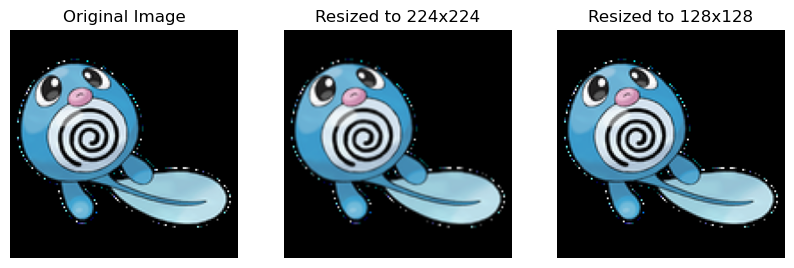

In [3]:
import cv2
import matplotlib.pyplot as plt

# Load the image (change the path to your image)
image_path = r'C:\Users\Samir\.cache\kagglehub\datasets\noodulz\pokemon-dataset-1000\versions\2\pokemon-dataset-1000\train\poliwag\poliwag_8.png'  # Replace with your image file path
image = cv2.imread(image_path)

# Convert the image from BGR (OpenCV's default) to RGB (for Matplotlib)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Resize the image to 224x224
resized_image = cv2.resize(image_rgb, (224, 224))

# Resize the image to 128x128 (optional, for comparison)
resized_image_128 = cv2.resize(image_rgb, (128, 128))

# Plotting the original and resized images for comparison
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis('off')

# Resized image (224x224)
plt.subplot(1, 3, 2)
plt.imshow(resized_image)
plt.title("Resized to 224x224")
plt.axis('off')

# Resized image (128x128 for comparison)
plt.subplot(1, 3, 3)
plt.imshow(resized_image_128)
plt.title("Resized to 128x128")
plt.axis('off')

plt.show()

In [5]:
train_dir = r'C:\Users\Samir\.cache\kagglehub\datasets\noodulz\pokemon-dataset-1000\versions\2\pokemon-dataset-1000\train'
test_dir = r'C:\Users\Samir\.cache\kagglehub\datasets\noodulz\pokemon-dataset-1000\versions\2\pokemon-dataset-1000\test'

In [7]:
from torchvision.transforms import v2
import torch
# Transformations for labeled and unlabeled data
transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Setting Device Agnostic Code


C:\Users\Samir\anaconda3\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [9]:
from torchvision import datasets

train_data = datasets.ImageFolder(root = train_dir ,transform = transform, target_transform=None)
test_data = datasets.ImageFolder(root = test_dir ,transform = transform, target_transform=None)

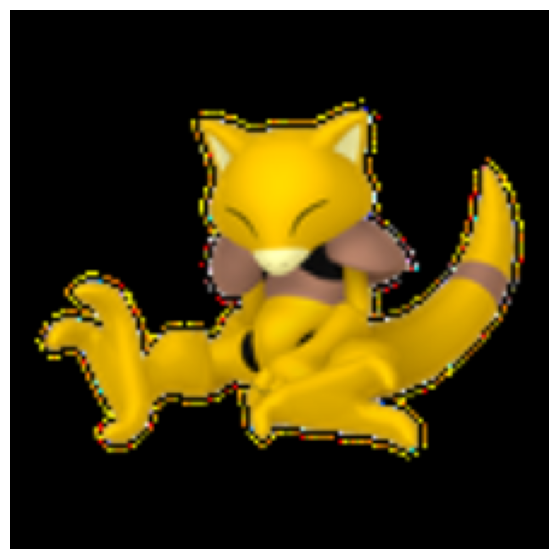

In [25]:
#train_data[5][0].shape
# Permute the dimensions to [H, W, C]
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
img_unorm =  train_data[60][0] * std[:, None, None] + mean[:, None, None]
img_clamped = torch.clamp(img_unorm, 0, 1)
img_permute = img_clamped.permute(1, 2, 0)

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")  # Turn off axis
#plt.title(class_names[label])  # Add a title with the class name
plt.show()

In [27]:
len(test_data),len(train_data)

(3239, 20921)

In [29]:
from torch.utils.data import DataLoader
# Training DataLoader
train_loader = DataLoader(
    train_data,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

In [124]:
import torch
import torch.nn as nn

class SimpleVGG8(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleVGG8, self).__init__()

        # Convolutional layers
        self.features = nn.Sequential(
            # Layer 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Layer 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Correct channel number
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Layer 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Layer 4
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Fully connected layers
        # Adjust size based on exact input image dimensions
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 14 * 14, 512),  # Assumes input image size of 224x224
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Determine the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create and move the model to the appropriate device
model = SimpleVGG8(num_classes=1000).to(device)


In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# 2. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 3. Training parameters
num_epochs = 7
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# 4. Training loop
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# 5. Evaluation function
def evaluate(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(test_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# 6. Training loop with both training and evaluation
print("Starting training...")
for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Evaluate
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    print('-' * 50)

# 7. Plot training history
plt.figure(figsize=(12, 4))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

Starting training...


 47%|████▋     | 305/654 [09:25<09:48,  1.69s/it]

In [65]:
from PIL import Image

# Load and preprocess the image
image_path = r'C:\Users\Samir\Downloads\252-Treecko.jpg'  # Replace with the path to your image
image = Image.open(image_path)
image = transform(image).unsqueeze(0)  # Add batch dimension

# Move the image to the same device as the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
image = image.to(device)

# Make a prediction
with torch.no_grad():
    output = model(image)
    _, predicted_class = torch.max(output, 1)

# Print the predicted class
print(f'Predicted class: {predicted_class.item()}')

class_to_idx = test_data.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
predicted_class_index = predicted_class.item()  # Example predicted index

# Retrieve the class label
predicted_class_label = idx_to_class.get(predicted_class_index, "Unknown Class")

print(f'Predicted class label: {predicted_class_label}')

Predicted class: 792
